# **FDA - Disaster Tweet Detection - Groupe 3**
## Models implementation, training and evaluation

This notebook is part of the contribution of the group 3 of IMT Atlantique in the FDA course

 - Kaggle comptetion : https://www.kaggle.com/code/charunumesh/nlp-disaster-tweets-lstm-transformers

 - Group's team : "BURBAN MATTHIEU"
 - Best score : 0.82470

**The notebook presents all the algorithms used during this challenge whether their implementation, their complete training or their final evaluation**

In [ ]:
# author: Anthammax https://github.com/anthammax
# date: 18/03/2023
# last_update : 19/03/2023, 14:52

# Importations

## Libraries

In [ ]:
## Install (once)
!pip install transformers
!pip install evaluate
!pip install datasets
!pip install keras-tcn

In [ ]:
## Libraries 

# Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cleaning
import re

# Evaluation, metrics, others
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from datasets import Dataset, DatasetDict

# Models
from sklearn import svm, ensemble
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


# Deep learning 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import callbacks, Sequential, regularizers, layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model #import model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Input, Dense, LSTM, Dropout,Embedding, concatenate,SpatialDropout1D,GlobalAveragePooling1D, GlobalMaxPooling1D

from tensorflow.python.keras.models import Input

import tcn
from tcn import TCN, tcn_full_summary

from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

## Import data

In [ ]:
## Drive connexion

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Dataset

# Kaggle dataset for training (columns = 'keyword', 'location', 'text', 'target')
data_train = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/train.csv',index_col=0)

# Dataset extracted from the previous part, home-made tokenization in 200 dimension (1 tweet = 1 row = 200dim)
data_tokenize = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/wordvec_train.csv',index_col=0)

# Kaggle dataset for submission (contains tweets to test)
data_sub = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/test.csv',index_col = 0)
data_sub = data_sub['text']

# Kaggle dataset with empty label for the submission
sample = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/sample_submission.csv',index_col=0)

# Empty Dataframe for all the results
results = pd.DataFrame(index=['accuracy','error rate','recall','precision','f1 score','Kaggle'])

In [ ]:
## Keep useful data
text = data_train['text'].tolist()
target  = data_train['target'].tolist()

data_target = data_tokenize['target']
data_tokenize = data_tokenize.drop(['target'], axis=1)

## Functions for evaluation

In [ ]:
def conf_matrix(y_pred,y_val):
  """
  Print a nice confusion matrix
  """
  title="Confusion Matrix"
  conf_matrix = confusion_matrix(y_pred,y_val,labels=[1,0])
  fig, ax = plt.subplots(1,1,figsize=(7,4))
  disp = ConfusionMatrixDisplay(conf_matrix,display_labels=['disaster tweet','usual tweet']).plot(values_format=".0f",ax=ax , cmap=plt.cm.Blues)

  ax.set_xlabel("True Label")
  ax.set_ylabel("Predicted Label")
  plt.title(title)
  plt.show()

def metrics(y_pred,y_val):
  """
  Print all basics metrics and return the values
  """
  conf_matrix = confusion_matrix(y_pred,y_val,labels=[1,0])
  TP = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  TN = conf_matrix[1][1]
  FN = conf_matrix[1][0]
  tot = TP+FP+TN+FN

  acc = round((TP+TN)/tot*100,2)
  er = round(100-acc,2)
  recall = round(TP/(TP+FN)*100,2) #quantity :high recall means that the algorithm returns most of the relevant results
  precision = round(TP/(TP+FP)*100,2) #measure of the quality
  f1 = round(f1_score(y_pred, y_val)*100,2) #trade-off btw recall and precision

  print("-------- Metrics ----------")
  print("Accuracy   :",acc,'%')
  print("Error rate :",er,'%')
  print("Recall     :",recall,'%')
  print("Precision  :",precision,'%')
  print("f1         :",f1,'%')
  print("----------------------------")

  return [acc,er,recall,precision,f1]

# Simple models
This part of the notebook is dedicated to simple models (which aren't based on neural networks). They allow a quite good score around 70% of correct answers

 
We tried on this part
- The Gradient Boosting 
- The Support Vector Classifier (SVC)

They were trained on the dataset `data_tokenize` of 200 dimensions 

In [ ]:
# Train and validation
X = data_tokenize.to_numpy()
Y = data_target.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

## SVC Model

In [ ]:
## Model and Training

model_svc = svm.SVC(kernel='linear', C = 1.0)
model_svc.fit(X_train,y_train)

SVC(kernel='linear')

In [ ]:
## Prediction evaluation

y_pred_svc = model_svc.predict(X_val)

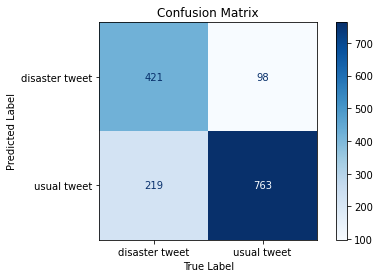

-------- Metrics ----------
Accuracy   : 78.88 %
Error rate : 21.12 %
Recall     : 65.78 %
Precision  : 81.12 %
f1         : 72.65 %
----------------------------


In [ ]:
## Tests
score_kaggle_svc = 76.31

conf_matrix(y_pred_svc,y_val)
results_svc = metrics(y_pred_svc,y_val)
results['SVC'] = results_svc + [score_kaggle_svc]

## Gradient Boosting 

In [ ]:
## Model and Training
model_GB = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)

model_GB.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [ ]:
## Prediction evaluation

y_pred_GB = model_GB.predict(X_val)

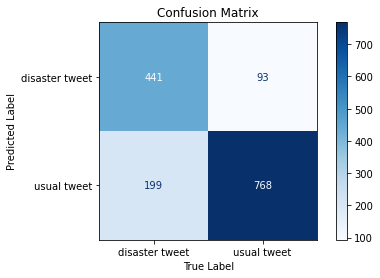

-------- Metrics ----------
Accuracy   : 80.55 %
Error rate : 19.45 %
Recall     : 68.91 %
Precision  : 82.58 %
f1         : 75.13 %
----------------------------


In [ ]:
## Tests
score_kaggle_GB = '-'

conf_matrix(y_pred_GB,y_val)
results_GB = metrics(y_pred_GB,y_val)
results['GB'] = results_GB + [score_kaggle_GB]

# Deep Learning Models - Part 1

This part of the notebook is deidcated to the discovery of DL models from the simplest one to the fined-tuning of the more complex one

We tried on this part
- A basic DL model for classification
- The Temporal Convolutional Network (TCN)

They were trained on the dataset `data_tokenize` of 200 dimensions 

## Basic NN1

In [ ]:
## Model

model_basicNN = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[200]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'), # the last layer compute a proba <0.5 the tweet is usual, overwhise it's disaster
])

model_basicNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
## Training

early_stopping = keras.callbacks.EarlyStopping(
    patience=10, 
    min_delta=0.001,
    restore_best_weights=True,
)

history = model_basicNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=1000, #BASE 1000
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.4620
Best Validation Accuracy: 0.7848


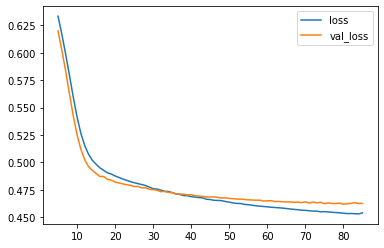

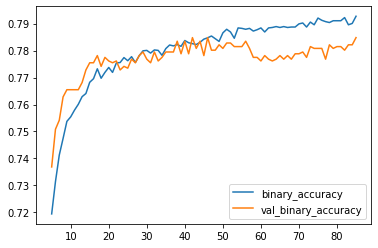

In [ ]:
## Evaluation 

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

47/47 [==============================] - 0s 2ms/step


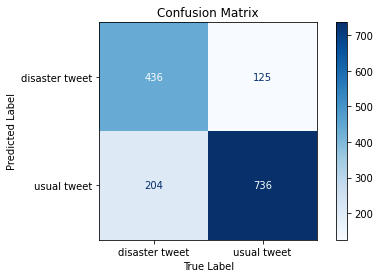

-------- Metrics ----------
Accuracy   : 78.08 %
Error rate : 21.92 %
Recall     : 68.12 %
Precision  : 77.72 %
f1         : 72.61 %
----------------------------


In [ ]:
## evaluation 

y_pred_basicNN = model_basicNN.predict(X_val) 
y_pred_basicNN = [0 if x<0.5 else 1 for x in y_pred_basicNN]
score_kaggle_basicNN = 76.40

conf_matrix(y_pred_basicNN,y_val)
results_basicNN = metrics(y_pred_basicNN,y_val)
results['Basic NN'] = results_basicNN + [score_kaggle_basicNN]

## TCN

Sources
- https://github.com/diardanoraihan/Text_Classification_Capstone/blob/main/3_WordEmbedding_Models/Word2Vec/2_TCN/TCN_CR.ipynb
- https://github.com/philipperemy/keras-tcn
- https://towardsdatascience.com/deep-learning-techniques-for-text-classification-78d9dc40bf7c

In [ ]:
## Model architecture

def define_model_TCN(kernel_size = 1, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

# Build the model
max = X_train.shape[1]
model_TCN = define_model_TCN( input_dim=1000, max_length=max)
model_TCN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 300)     300000      ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 200, 300)    0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 tcn1 (TCN)                     (None, 200, 128)     400256      ['spatial_dropout1d_2[0][0]

In [ ]:
##  Train the model

# Create a callback that stop the epoch when the model overfit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

#-----------------------------------------#
# Unknown package error - Grpah error     #
#-----------------------------------------#

#model_TCN.fit(X_train, y_train, batch_size=50, epochs=50, verbose=1)
# => we used the load_model 

#model_TCN = load_model('/content/drive/MyDrive/FDA_Challenge/Models/model_TCN')

In [ ]:
## Evaluation 

score_kaggle_TCN = 76.34

#conf_matrix(y_pred_LSTM1,Y_val)
#results_LSTM1 = metrics(y_pred_LSTM1,y_val)
results['TCN'] = ['-','-','-','-','-'] + [score_kaggle_TCN]

# Deep Learning Models - Part 2

In this last part we are using the best models to solve our problems but we keep the winnign one for the part 3 

We tried on this part
- Long Short Term Memory (LSTM1)
- Long Short Term Memory (LSTM2)

These model didn't trained on the previous dataset ```data_tokenize``` because the preprocessing requiers antoher approach. There is LSTM1 & 2 because their architectures are a little bit different



## Preprocessing 

We start from scratch with the brut tweets (in    ```data_train```) because we have to deal with another type of tokenization which is more accurate.

So first, let's clean the data as usual


Source : https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

### Cleaning & tokenization


In [ ]:
def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str:
    """
    A method to clean text 
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string        

In [ ]:
## Clean the text

X = [clean_text(text) for text in text]
Y = np.asarray(target)

In [ ]:
## Split in train and val

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

In [ ]:
## Tokenizing the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #compute de token in intern memory

In [ ]:
## Useful command to deal with tokenizer
"""
tokenizer.word_index #Dictonnary of unique word in the all X_train
tokenizer.texts_to_sequences(X_train) #Matrix of each tweet with worlds indexed in the previous dic
"""

'\ntokenizer.word_index #Dictonnary of unique word in the all X_train\ntokenizer.texts_to_sequences(X_train) #Matrix of each tweet with worlds indexed in the previous dic\n'

In [ ]:
print("The entire dataset contains ",len(tokenizer.word_index)," unique words")

The entire dataset contains  15726  unique words


At this step 

- **We cleaned the data :**

  For exemple we transform ```We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw``` into ```we always try to bring heavy metal rt``` 

- **We tokenize the text :**

  - ```tokenizer.word_index``` gives a dictionnary of all words used in the dataset, and indexed them
  - ```tokenizer.texts_to_sequences(X_train)``` gives a dictionnary of all tweets, containing labeled words 

This step is fundamental to understanc the next one, **the embeding**

### Embeding Matrix

What is an embeding matrix ?

This matrix of shape (nb_rows = number of unique words / nb_columns = dimensions choose) contains for each unique word its mathematical representation in a vector of X dimension. To access these vectors we have to download a txt file, resulting of a huge training on very big data set (Wikipedia4, ...). The model behind in a neural network that contains one input layer, one hidden layer, and one output layer.

**=> The goal is to find a mathematical representation of each word <=**


All glove dataset are available here
https://nlp.stanford.edu/projects/glove/

In this notebook we have used two glove files:
- a very large dataset of 300 dimensions called ```glove.840B.300d.txt```
- a smaller on of 50 dimensions, specialized in tweets called ```glove.twitter.27B.50d.txt```





In [ ]:
def create_embedding_matrix(path, vector_dimension, tokenizer, max_features):
  """
  A method to create the embedding matrix
  """
  def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')


  model_embed = dict(get_coefs(*o.split(" ")) for o in open(path, errors='ignore'))

  embedding_matrix = np.zeros((max_features + 1, vector_dimension))
  for word, index in tokenizer.word_index.items():
    if index > max_features:
       break
    else:
       try:
         embedding_matrix[index] = model_embed[word]
       except:
         continue
  return embedding_matrix

In [ ]:
## Creating the embedding matrix

path_300d = '/content/drive/MyDrive/FDA_Challenge/Models/glove/glove.840B.300d.txt'
path_50d = '/content/drive/MyDrive/FDA_Challenge/Models/glove/glove.twitter.27B.50d.txt'

max_features = len(tokenizer.word_counts)

embedding_matrix_300d = create_embedding_matrix(path_300d, 300 , tokenizer, max_features)
embedding_matrix_50d = create_embedding_matrix(path_50d, 50, tokenizer, max_features)

In [ ]:
print(embedding_matrix_300d.shape)
print(embedding_matrix_50d.shape)

(15727, 300)
(15727, 50)


### Create the input Tensor

In [ ]:
def string_to_tensor(tokenizer, max_len, string_list: list) -> list:
  """
  A method to convert a string list to a tensor for a deep learning model
  """    
  string_list = tokenizer.texts_to_sequences(string_list)
  string_list = pad_sequences(string_list, maxlen=max_len)
        
  return string_list

In [ ]:
# Creating the padded input for the deep learning model
max_len = np.max([len(text.split()) for text in X_train])
X_train = string_to_tensor(tokenizer, max_len,X_train)

## LSTM 1 - 300 dimensions

In [ ]:
## The model

def get_model_LSTM1(embedding_matrix, embedding_dim, max_len, X_additional=None):

  inp1 = Input(shape=(max_len,))
  x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix])(inp1)
  x = Bidirectional(LSTM(256, return_sequences=True))(x)
  x = Bidirectional(LSTM(150))(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation="relu")(x)
  x = Dense(1, activation="sigmoid")(x)    
  model = Model(inputs=inp1, outputs=x)

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
  
  return model

In [ ]:
# Create a callback that stop the epoch when the model overfit

callbacks = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [ ]:
## Create the model
epochs = 10
batch_size = 256
embed_dimension = 300

model_LSTM1 = get_model_LSTM1(
            embedding_matrix=embedding_matrix_300d, 
            embedding_dim= embed_dimension, 
            max_len=max_len)

model_LSTM1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 29)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 29, 300)           4718100   
                                                                 
 bidirectional (Bidirectiona  (None, 29, 512)          1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              795600    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               38528     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0   

In [ ]:
## Training
model_LSTM1.fit(X_train,Y_train,
              batch_size=batch_size,
              epochs=epochs
              )

Epoch 1/10
24/24 [==============================] - 92s 3s/step - loss: 0.4975
Epoch 2/10
24/24 [==============================] - 95s 4s/step - loss: 0.3719
Epoch 3/10
24/24 [==============================] - 83s 4s/step - loss: 0.2960
Epoch 4/10
24/24 [==============================] - 88s 4s/step - loss: 0.2083
Epoch 5/10
24/24 [==============================] - 66s 3s/step - loss: 0.1477
Epoch 6/10
24/24 [==============================] - 66s 3s/step - loss: 0.1032
Epoch 7/10
24/24 [==============================] - 110s 5s/step - loss: 0.0742
Epoch 8/10
24/24 [==============================] - 103s 4s/step - loss: 0.0497
Epoch 9/10
24/24 [==============================] - 97s 4s/step - loss: 0.0395
Epoch 10/10
24/24 [==============================] - 75s 3s/step - loss: 0.0387


In [ ]:
## Prediction

X_val2 = string_to_tensor(tokenizer, max_len,X_val)
yhat = [x[0] for x in model_LSTM1.predict(X_val2).tolist()]
y_pred_LSTM1 = [1 if x > 0.5 else 0 for x in yhat]


48/48 [==============================] - 13s 235ms/step


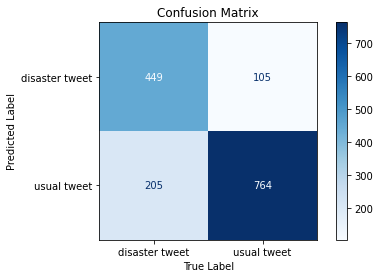

-------- Metrics ----------
Accuracy   : 79.65 %
Error rate : 20.35 %
Recall     : 68.65 %
Precision  : 81.05 %
f1         : 74.34 %
----------------------------


In [ ]:
## Evaluation 

score_kaggle_LSTM1 = 78.24

conf_matrix(y_pred_LSTM1,Y_val)
results_LSTM1 = metrics(y_pred_LSTM1,Y_val)
results['LSTM1'] = results_LSTM1 + [score_kaggle_LSTM1]

In [ ]:
## Save Model

#model_LSTM1.save('/content/drive/MyDrive/FDA_Challenge/Models/model_LSTM1') 

## LSTM 2 - 50 dimensions

In [ ]:
## The model

def get_model_LSTM2(embedding_matrix, embedding_dim):

  # build the model
  model = Sequential()
  model.add(Embedding(embedding_matrix.shape[0],embedding_dim, weights = [embedding_matrix], trainable=True))
  model.add(Bidirectional(LSTM(25, dropout=0.1)))
  model.add(Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.1))
  model.add(Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.1))
  model.add(Dense(2,activation = 'sigmoid'))

  # compile
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(
      optimizer = optimizer,
      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
  )

  return model

In [ ]:
## Create the model

embedding_dim = 50

model_LSTM2 = get_model_LSTM2(embedding_matrix_50d, embedding_dim)
model_LSTM2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 50)          786350    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 25)                1275      
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_16 (Dense)            (None, 12)                312       
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                      

In [ ]:
## callbacks

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, 
                                                  patience=2, verbose=1, min_lr=1e-7)
acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                              patience=10, verbose=2, 
                                              mode='auto', restore_best_weights=True)

callbacks = [reduce_lr, acc]

In [ ]:
## Training

y_train = to_categorical(Y_train) 
x_val = string_to_tensor(tokenizer, embedding_dim, X_val)
y_val = to_categorical(Y_val)

model_LSTM2.fit(
    X_train, y_train,
    validation_data=(x_val, y_val), 
    batch_size = 32,
    epochs = 50,
    callbacks = callbacks)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


191/191 [==============================] - 30s 96ms/step - loss: 1.0173 - accuracy: 0.4720 - precision: 0.4712 - recall: 0.4576 - val_loss: 0.9792 - val_accuracy: 0.5167 - val_precision: 0.5240 - val_recall: 0.3657 - lr: 1.0000e-04
Epoch 2/50
191/191 [==============================] - 14s 75ms/step - loss: 0.9447 - accuracy: 0.5768 - precision: 0.5780 - recall: 0.5695 - val_loss: 0.9085 - val_accuracy: 0.6664 - val_precision: 0.6841 - val_recall: 0.6185 - lr: 1.0000e-04
Epoch 3/50
191/191 [==============================] - 16s 84ms/step - loss: 0.8378 - accuracy: 0.7034 - precision: 0.6843 - recall: 0.7553 - val_loss: 0.7651 - val_accuracy: 0.7705 - val_precision: 0.7700 - val_recall: 0.7715 - lr: 1.0000e-04
Epoch 4/50
191/191 [==============================] - 23s 123ms/step - loss: 0.7346 - accuracy: 0.7486 - precision: 0.7427 - recall: 0.7608 - val_loss: 0.6929 - val_accuracy: 0.7814 - val_precision: 0.7814 - val_recall: 0.7814 - lr: 1.0000e-04
Epoch 5/50
191/191 [==================

In [ ]:
## Prediction

X_val_tensor = string_to_tensor(tokenizer, max_len,X_val)
yhat = [x[0] for x in model_LSTM2.predict(X_val_tensor).tolist()]
y_pred_LSTM2 = np.array([1 if x < 0.5 else 0 for x in yhat])

48/48 [==============================] - 1s 15ms/step


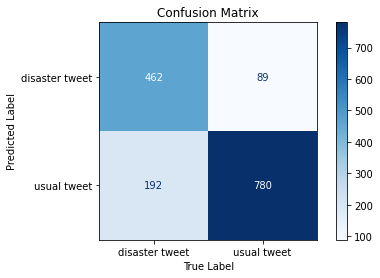

-------- Metrics ----------
Accuracy   : 81.55 %
Error rate : 18.45 %
Recall     : 70.64 %
Precision  : 83.85 %
f1         : 76.68 %
----------------------------


In [ ]:
## Evaluation 

score_kaggle_LSTM2 = 78.55

conf_matrix(y_pred_LSTM2,Y_val)
results_LSTM2 = metrics(y_pred_LSTM2,Y_val)
results['LSTM2'] = results_LSTM2 + [score_kaggle_LSTM2]

In [ ]:
## Save Model

#model_LSTM2.save('/content/drive/MyDrive/FDA_Challenge/Models/model_LSTM2') 

# Deep Learning - Part 3

In this last part, we are implementing a fine-tuned technic thanks to the BERT algorithm for **Bidirectional Encoder Representations from Transformers**, developped by google.

The dataset isn't the same as the previous one, that's to say that the preprocessing isn't the same

Source : 
https://www.kaggle.com/code/charunumesh/nlp-disaster-tweets-lstm-transformers

## Preprocessing

In [ ]:
## Define the pretrained model we use

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # Define which pre-trained model we will be using
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # Get the classifier
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # Get the tokenizer

In [ ]:
df_tra = data_train.loc[:, ['text', 'target']]

# Split the dataset
df_train, df_test= train_test_split(df_tra, train_size=0.8,stratify=df_tra.target, random_state=42)

# Convert pandas dataframe into datasetra
data = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})

In [ ]:
## Tokenization

tokenized_datasets = data.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'id', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'target', 'id', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})


In [ ]:
# Remove usel columns form tokenized_datasets
tokenized_datasets = tokenized_datasets.remove_columns(["text", "id"])

#Also we will rename "target" to "labels", as Trainer API require the target to be named "labels"
tokenized_datasets = tokenized_datasets.rename_column("target", "labels")
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})


## Model

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments('test-trainer', num_train_epochs=1, evaluation_strategy='epoch',
                                 weight_decay=5e-4, save_strategy='no', report_to='none')

# Metric for validation error
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc") # F1 and Accuracy
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define trainer
model_BERT_ft = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
## Training
model_BERT_ft.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.496100,0.389118,0.845043,0.809677


TrainOutput(global_step=762, training_loss=0.468186546185511, metrics={'train_runtime': 3087.2752, 'train_samples_per_second': 1.973, 'train_steps_per_second': 0.247, 'total_flos': 79337105328648.0, 'train_loss': 0.468186546185511, 'epoch': 1.0})

In [ ]:
## Evaluation

# Get the test data
df_test = pd.DataFrame(X_val,columns=['text'])
df_test = df_test.loc[:,["text"]] # Keep only text

# Turn the DataFrame into appropriate format
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
test_dataset = test_dataset.remove_columns('text')

# Get the prediction
predictions = model_BERT_ft.predict(test_dataset)
y_pred_BERT = np.argmax(predictions.predictions, axis=-1)


Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

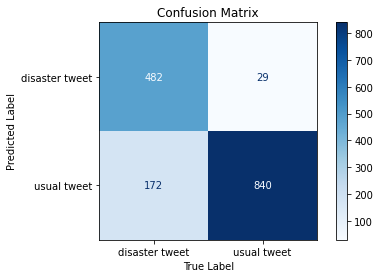

-------- Metrics ----------
Accuracy   : 86.8 %
Error rate : 13.2 %
Recall     : 73.7 %
Precision  : 94.32 %
f1         : 82.75 %
----------------------------


In [ ]:
## Metrics 
score_kaggle_BERT = 82.47

conf_matrix(y_pred_BERT,Y_val)
results_BERT = metrics(y_pred_BERT,Y_val)
results['BERT'] = results_BERT + [score_kaggle_BERT]

In [ ]:
## Save Model

#model_BERT.save_model('/content/drive/MyDrive/FDA_Challenge/Models/model_BERT') 

In [ ]:
# Use the saved model (model trained)
"""
from tensorflow.keras.models import load_model #import model

# Create a basic model instance
model_test2 = load_model('/content/drive/MyDrive/FDA_Challenge/test/model_0')
"""

# Submission

In [ ]:
def result_BERT(model, X):
  """
  return the resulting list of the BERT algorithm with the dataset X in input
  """
  # Get the test data
  df_test = pd.DataFrame(X,columns=['text'])
  df_test = df_test.loc[:,["text"]] # Keep only text

  # Turn the DataFrame into appropriate format
  test_dataset = Dataset.from_pandas(df_test)
  test_dataset = test_dataset.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
  test_dataset = test_dataset.remove_columns('text')

  # Get the prediction
  predictions = model.predict(test_dataset)
  preds = np.argmax(predictions.predictions, axis=-1)

  return preds

In [ ]:
## Import
model_sub = model_BERT_ft
name = '5_BERT.csv'

data_sub = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/test.csv',index_col = 0)
data_sub = data_sub['text']

## Prediction
results_kaggle = result_BERT(model_sub, data_sub)

sample = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/sample_submission.csv',index_col=0)
sample['target'] = results_kaggle

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [ ]:
## Import
model_sub = trainer
name = '5_BERT.csv'

data_sub = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/test.csv',index_col = 0)
data_sub = data_sub['text']

#prediction
X_sub = data_sub.to_list()
X_sub = string_to_tensor(tokenizer, max_len,X_sub)

Y_sub = [x[0] for x in model.predict(X_sub).tolist()]
results_kaggle = [0 if x > 0.5 else 1 for x in Y_sub]


sample = pd.read_csv('/content/drive/MyDrive/FDA_Challenge/Base_de_donnees/sample_submission.csv',index_col=0)
sample['target'] = results_kaggle

In [ ]:
## Save the results

sample.to_csv('/content/drive/MyDrive/FDA_Challenge/Fichier_Kaggle/'+name)

#Final results

In [ ]:
results

,SVC,GB,Basic NN,TCN,LSTM1,LSTM2,BERT
accuracy,78.88,80.55,78.08,-,79.65,81.55,86.80
error rate,21.12,19.45,21.92,-,20.35,18.45,13.20
recall,65.78,68.91,68.12,-,68.65,70.64,73.70
precision,81.12,82.58,77.72,-,81.05,83.85,94.32
f1 score,72.65,75.13,72.61,-,74.34,76.68,82.75
Kaggle,76.31,-,76.40,76.34,78.24,78.55,82.47


In [ ]:
## Export the results

results.to_csv('/content/drive/MyDrive/FDA_Challenge/all_resultst')

**END**